<a href="https://colab.research.google.com/github/coderacheal/Its-Sunday/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cu117, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
...,...,...,...
937849,@Juice_Lemons in the dark. it’s so good,en,positive
937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
937852,@reblavoie So happy for her! She’s been incred...,en,positive


In [5]:
df.shape

(937854, 3)

In [6]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

In [7]:
english_df = df[df['Language'] =='en']
english_df = english_df[:250000]

In [8]:
english_df['Language'].unique()

array(['en'], dtype=object)

## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


In [10]:
sentiments = english_df['Label'].value_counts().sort_values(ascending=False)
sentiments

positive       71322
negative       70177
uncertainty    56786
litigious      51715
Name: Label, dtype: int64

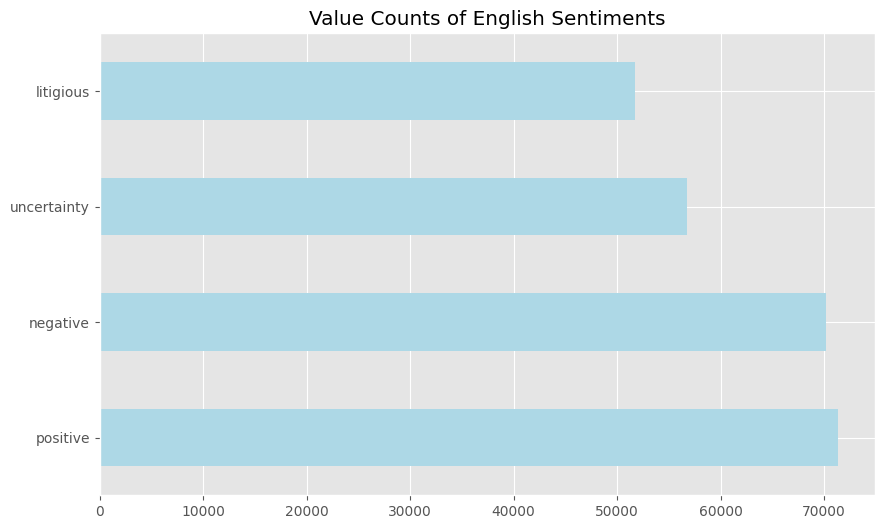

In [11]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

### Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and \n form tweet

##### Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re module

In [12]:
# before
english_df['Text'][0]

'@Charlie_Corley @Kristine1G @amyklobuchar @StyleWriterNYC testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [13]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


english_df['Text'] = english_df['Text'].apply(remove_usernames)
english_df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative
...,...,...,...
268945,Incredible! 👀👏,en,positive
268946,https://t.co/1MZf0yj7ym Honored to be named as...,en,positive
268947,That was the original smart contract.,en,litigious
268948,I’d be willing to bet 60% or more of the guys ...,en,positive


In [14]:
# after
english_df['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

##### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [15]:
# before
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n#SovereignGroup #SovereignAfrica #UNDP #Rwanda'

In [16]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


english_df['Text'] = english_df['Text'].apply(remove_hastags)
english_df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative
...,...,...,...
268945,Incredible! 👀👏,en,positive
268946,https://t.co/1MZf0yj7ym Honored to be named as...,en,positive
268947,That was the original smart contract.,en,litigious
268948,I’d be willing to bet 60% or more of the guys ...,en,positive


#### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [17]:
#after there are not more hashtags
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

##### Next, http links

- We need to remove all http links.
- Write a function using the re module

In [18]:
#before
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

In [19]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

english_df['Text'] = english_df['Text'].apply(remove_urls)

In [20]:
#after
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n'


##### Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [21]:
#before
english_df['Text'].unique()

array(['testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination',
       ' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals ',
       'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n',
       ..., 'That was the original smart contract.',
       'I’d be willing to bet 60% or more of the guys in SL are more physical than Austin. That’s not how or why he made the league, he needs to improve there.\n\nIt worked great for THT right? Let’s try it again! 🤦\u200d♂️',
       'Just finished up an anatomy scan and bbygrl looks like her dad.. I’m excited to see the accuracy of these photos once Sophia Kyalida is finally here. Fingers crossed Embry will look like mama so we can both have our minis. 😬😬😬'],
      dtype=object)

In [22]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

english_df['Text'] = english_df['Text'].apply(remove_special_chars)

In [23]:
#let's drop the language column

data = english_df
data.drop(columns='Language', inplace=True)
data

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,Flagstar Bank discloses a data breach that im...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative
...,...,...
268945,Incredible! 👀👏,positive
268946,Honored to be named as an honorable mention f...,positive
268947,That was the original smart contract.,litigious
268948,I’d be willing to bet 60% or more of the guys ...,positive


#### Creating Tokenizer and Model

Let's convert our text and label column into list for easy splitting



In [24]:
X = data['Text'].to_list()
y = data['Label'].to_list()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Load RoBERTa tokenizer and encode text

In [25]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = y_train


test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = y_test

In [26]:
# import tensorflow as tf
# tf.test.gpu_device_name()


'/device:GPU:0'

In [27]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create train and test datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [28]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [29]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,